## 17.1 Tutorial Overview
This tutorial is divided into four parts; they are:
1. Problem Description
2. Load and Prepare Dataset
3. Model Evaluation
4. Develop Naive Forecast Models

## 17.2 Problem Description
The Household Power Consumption dataset is a multivariate time series dataset that describes the electricity consumption for a single household over four years. The data was collected between December 2006 and November 2010 and observations of power consumption within the household were collected every minute. It is a multivariate series comprised of seven variables
(besides the date and time); they are:
- global_active_power: The total active power consumed by the household (kilowatts).
- global_reactive_power: The total reactive power consumed by the household (kilowatts). 􏰀 
- voltage: Average voltage (volts).
- global_intensity: Average current intensity (amps).
- sub_metering_1: Active energy for kitchen (watt-hours of active energy).
- sub_metering_2: Active energy for laundry (watt-hours of active energy).
- sub_metering_3: Active energy for climate control systems (watt-hours of active energy).

Active and reactive energy refer to the technical details of alternative current. A fourth sub-metering variable can be created by subtracting the sum of three defined sub-metering variables from the total active energy. 

## 17.3 Load and Prepare Dataset


1. The dataset can be downloaded as a single 20 megabyte zip file. A direct download link is provided below: https://raw.githubusercontent.com/jbrownlee/Datasets/master/household_power_consumption.zip

2. we can mark all missing values indicated with a ‘?’ character with a NaN value, which is a float. This will allow us to work with the data as one array of floating point values rather than mixed types (less efficient.)

3. We also need to fill in the missing values now that they have been marked. A very simple approach would be to copy the observation from the same time the day before. We can implement this in a function named fill missing() that will take the NumPy array of the data and copy values from exactly 24 hours ago.

4. Now we can create a new column that contains the remainder of the sub-metering, using the calculation from the previous section.


In [1]:
# load and clean-up the power usage dataset
from numpy import nan
from numpy import isnan
from pandas import read_csv

# fill missing values with a value at the same time one day ago
def fill_missing(values):
	one_day = 60 * 24
	for row in range(values.shape[0]):
		for col in range(values.shape[1]):
			if isnan(values[row, col]):
				values[row, col] = values[row - one_day, col]

# load all data
dataset = read_csv('household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
# mark all missing values
dataset.replace('?', nan, inplace=True)
# make dataset numeric
dataset = dataset.astype('float32')
# fill missing
fill_missing(dataset.values)
# add a column for for the remainder of sub metering
values = dataset.values
dataset['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])
# save updated dataset
dataset.to_csv('household_power_consumption.csv')

## 17.4 Model Evaluation
In this section, we will consider how we can develop and evaluate predictive models for the household power dataset. This section is divided into four parts; they are:
1. Problem Framing
2. Evaluation Metric
3. Train and Test Sets
4. Walk-Forward Validation

### 17.4.1 Problem Framing

1. There are many ways to harness and explore the household power consumption dataset. In this tutorial, we will use the data to explore a very specific question; that is: __Given recent power consumption, what is the expected power consumption for the week ahead?__ This requires that a predictive model forecast the total active power for each day over the next seven days. Technically, this framing of the problem is referred to as a multi-step time series forecasting problem, given the multiple forecast steps. 

2. This framing of the dataset also suggests that it would be useful to downsample the per-minute observations of power consumption to daily totals. This is not required, but makes sense, given that we are interested in total power per day. We can achieve this easily using the __resample()__ function on the Pandas DataFrame. Calling this function with the argument __‘D’__ allows the loaded data indexed by date-time to be grouped by day (see all offset aliases). We can then calculate the sum of all observations for each day and create a new dataset of daily power consumption data for each of the eight variables. 

In [2]:
# resample minute data to total for each day for the power usage dataset
from pandas import read_csv
# load the new file
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# resample data to daily
daily_groups = dataset.resample('D')
daily_data = daily_groups.sum()
# summarize
print(daily_data.shape)
print(daily_data.head())
# save
daily_data.to_csv('household_power_consumption_days.csv')

(1442, 8)
            Global_active_power  Global_reactive_power    Voltage  \
datetime                                                            
2006-12-16             1209.176                 34.922   93552.53   
2006-12-17             3390.460                226.006  345725.32   
2006-12-18             2203.826                161.792  347373.64   
2006-12-19             1666.194                150.942  348479.01   
2006-12-20             2225.748                160.998  348923.61   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
datetime                                                                       
2006-12-16            5180.8             0.0           546.0          4926.0   
2006-12-17           14398.6          2033.0          4187.0         13341.0   
2006-12-18            9247.2          1063.0          2621.0         14018.0   
2006-12-19            7094.0           839.0          7602.0          6197.0   
2006-12-20            9313

### 17.4.2 Evaluation Metric

It is common with multi-step forecasting problems to evaluate each forecasted time step separately. This is helpful for a few reasons:
- To comment on the skill at a specific lead time (e.g. +1 day vs +3 days).
- To contrast models based on their skills at different lead times (e.g. models good at +1 day vs models good at days +5).

(the same model in the different days' prediction; the different models may also perform different in the different days' prediction)

__Unlike MAE, RMSE is more punishing of forecast errors.__ The performance metric for this problem will be the RMSE for each lead time from day 1 to day 7.As a short-cut, it may be useful to summarize the performance of a model using a single score in order to aide in model selection. One possible score that could be used would be the RMSE across all forecast days. 

### 17.4.3 Train and Test Sets

1. We will split the data into standard weeks, working backwards from the test dataset. The final year of the data is in 2010 and the first Sunday for 2010 was January 3rd. The data ends in mid November 2010 and the closest final Saturday in the data is November 20th. This gives 46 weeks of test data.
2. The daily data starts in late 2006. The first Sunday in the dataset is December 17th, which is the second row of data. Organizing the data into standard weeks gives 159 full standard weeks for training a predictive model.

In [3]:
# split the power usage dataset into standard weeks
from numpy import split
from numpy import array
from pandas import read_csv

# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
train, test = split_dataset(dataset.values)
# validate train data
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
# validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

(159, 7, 8)
3390.46 1309.2679999999998
(46, 7, 8)
2083.4539999999984 2197.006000000004


### 17.4.4 Walk-Forward Validation

Models will be evaluated using a scheme called walk-forward validation. This is where a model is required to make a one week prediction, then the actual data for that week is made available to the model so that it can be used as the basis for making a prediction on the subsequent week.

Input,　　　　　　　　　　　　Predict　<br>
[Week1] 　　　　　　　　　　　Week2<br>
[Week1 + Week2] 　　　　　　 Week3<br>
[Week1 + Week2 + Week3] 　 Week4<br>
．．．．．

## 17.5 Develop Naive Forecast Models

In this section, we will develop and compare three naive forecast methods for the household power prediction problem; they are:
1. Daily Persistence Forecast.
2. Weekly Persistent Forecast.
3. Weekly One-Year-Ago Persistent Forecast.

### 17.5.1 Daily Persistence Forecast

The first naive forecast that we will develop is a daily persistence model. This model takes the active power from the last day prior to the forecast period (e.g. Saturday) and uses it as the value of the power for each day in the forecast period (Sunday to Saturday). 

### 17.5.2 Weekly Persistent Forecast

Another good naive forecast when forecasting a standard week is to use the entire prior week as the forecast for the week ahead. 

### 17.5.3 Weekly One-Year-Ago Persistent Forecast
Similar to the idea of using last week to forecast next week is the idea of using the same week last year to predict next week. That is, use the week of observations from 52 weeks ago as the forecast, based on the idea that next week will be similar to the same week one year ago. 

### 17.5.4 Naive Model Comparison

We can compare each of the forecast strategies using the test harness developed in the previous section. Each of the strategies can be stored in a dictionary against a unique name. 

daily: [511.886] 452.9, 596.4, 532.1, 490.5, 534.3, 481.5, 482.0
weekly: [469.389] 567.6, 500.3, 411.2, 466.1, 471.9, 358.3, 482.0
week-oya: [465.294] 550.0, 446.7, 398.6, 487.0, 459.3, 313.5, 555.1


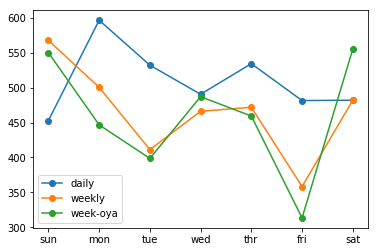

In [7]:
# naive forecast strategies for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
%matplotlib inline

# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# evaluate a single model
def evaluate_model(model_func, train, test):
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = model_func(history)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	predictions = array(predictions)
	# evaluate predictions days for each week
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

# daily persistence model
def daily_persistence(history):
	# get the data for the prior week
	last_week = history[-1]
	# get the total active power for the last day
	value = last_week[-1, 0]
	# prepare 7 day forecast
	forecast = [value for _ in range(7)]
	return forecast

# weekly persistence model
def weekly_persistence(history):
	# get the data for the prior week
	last_week = history[-1]
	return last_week[:, 0]

# week one year ago persistence model
def week_one_year_ago_persistence(history):
	# get the data for the prior week
	last_week = history[-52]
	return last_week[:, 0]

# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# define the names and functions for the models we wish to evaluate
models = dict()
models['daily'] = daily_persistence
models['weekly'] = weekly_persistence
models['week-oya'] = week_one_year_ago_persistence
# evaluate each model
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
for name, func in models.items():
	# evaluate and get scores
	score, scores = evaluate_model(func, train, test)
	# summarize scores
	summarize_scores(name, score, scores)
	# plot scores
	pyplot.plot(days, scores, marker='o', label=name)
# show plot
pyplot.legend()
pyplot.show()

Running the example first prints the total and daily scores for each model. We can see that the weekly strategy performs better than the daily strategy and that the week one year ago (week-oya) performs slightly better again. We can see this in both the overall RMSE scores for each model and in the daily scores for each forecast day. One exception is the forecast error for the first day (Sunday) where it appears that the daily persistence model performs better than the two weekly strategies. We can use the week-oya strategy with an overall RMSE of 465.294 kilowatts as the baseline in performance for more sophisticated models to be considered skillful on this specific framing of the problem. 


A line plot of the daily forecast error is also created. We can see the same observed pattern of the weekly strategies performing better than the daily strategy in general, except in the case of the first day. It is surprising (to me) that the week one-year-ago performs better than using the prior week. I would have expected that the power consumption from last week to be more relevant. 

## 17.7 Further Reading
This section provides more resources on the topic if you are looking to go deeper.
- pandas.read csv API.https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html
- numpy.split API. https://docs.scipy.org/doc/numpy/reference/generated/numpy.split.html
- pandas.DataFrame.resample API. https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html
- Resample Offset Aliases. http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases
- sklearn.metrics.mean squared error API. http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html

## 17.8 Summary
In this tutorial, you discovered how to develop a test harness for the household power consumption dataset and evaluate three naive forecast strategies that provide a baseline for more sophisticated algorithms. Specifically, you learned:
- How to load, prepare, and downsample the household power consumption dataset ready for modeling.
- How to develop metrics, dataset split, and walk-forward validation elements for a robust test harness for evaluating forecasting models.
- How to develop and evaluate and compare the performance a suite of naive persistence forecasting methods.